# Data Pipeline Example: Google Cloud Platform Applications
&nbsp;

In this project, I demonstrate the steps to **create a data pipeline using Python and various Google Cloud Platform** tools.
&nbsp;

First, **API calls are used to extract public raw data from the official U.S. statistics database**. The data is then **loaded into BigQuery** for further transformation. Finally, the data is **loaded into Looker** to create a dashboard.

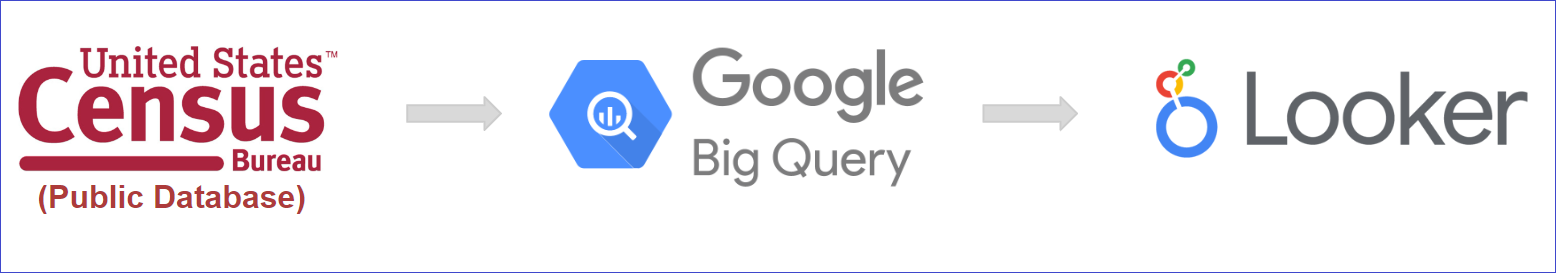

In [15]:
Image(filename='../img/pipeline.png')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-Data-extraction-" data-toc-modified-id="-Data-extraction--1"><span style="color: steelblue"> Data extraction </span></a></span></li><li><span><a href="#-Loading-into-BigQuery-" data-toc-modified-id="-Loading-into-BigQuery--2"><span style="color: steelblue"> Loading into BigQuery </span></a></span></li><li><span><a href="#-Loading-into-Looker-" data-toc-modified-id="-Loading-into-Looker--3"><span style="color: steelblue"> Loading into Looker </span></a></span></li></ul></div>

In [20]:
import pandas as pd
import numpy as np
import requests
import ast
from tqdm.notebook import tqdm
import html5lib
from google.cloud import bigquery
import pandas_gbq
from PIL import Image
from IPython.display import Image

&nbsp; 

## <span style='color:steelblue'> Data extraction </span>

The data is located in the **U.S. Census Bureau public database** and I used my API key to extract a dataset which contains **the country's population numbers broke down by state, age and sex**. 

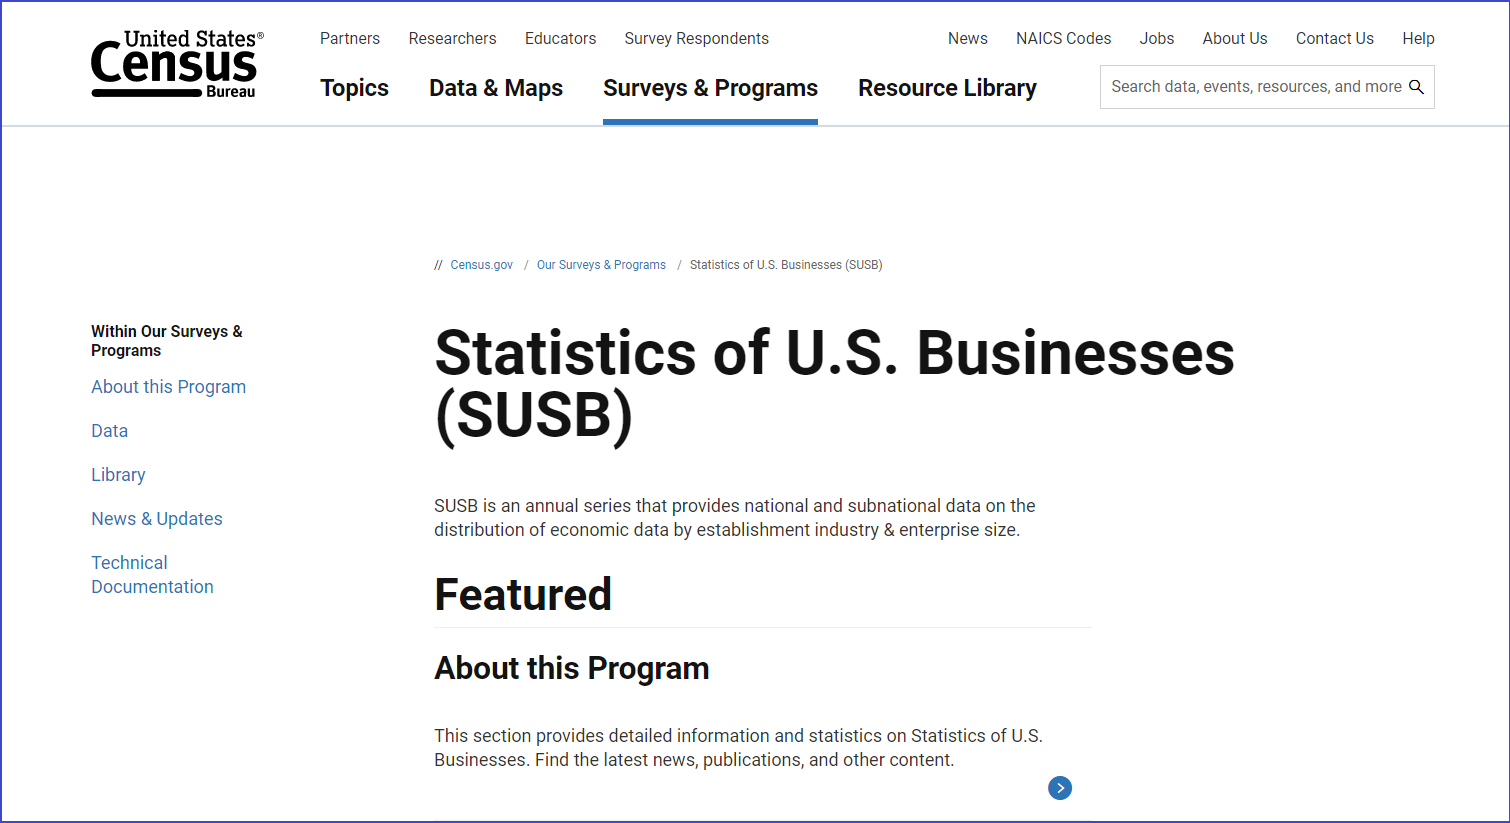

In [16]:
Image(filename='../img/database.png')

&nbsp;

In the following code **the API call is tested first and the status code is checked to verify that the request's response is successful**. 



In [14]:
# Creating variables for API call

base_url = 'https://api.census.gov/data'
year = '/2021'
dataset = '/acs/acs1'
get = '?get='
variables = 'NAME,B01001_026E'
geo = '&for=us:*'
db_api_key = # my personal API key

In [76]:
# Get data
query = f"{base_url}{year}{dataset}{get}{variables}{geo}{db_api_key}"
data = requests.request("GET", query)
# Verify request has succeeded
data.status_code

200

In [77]:
data.text

'[["NAME","B01001_026E","us"],\n["United States","167543042","1"]]'

&nbsp;

This is a very extensive dataset, so in the code below I demonstrate through a series of functions **how to automate the API calls to extract only a subset of interest from the dataframe**. 
For the sake of this example, let our variables of interest be the **total population of female individuals**, as well as its breakdown by groups **up until the age of 29 years** in the last 5 years and for the whole of the U.S.



In [21]:
# Functions to extract variable names and variables of interest

def get_variable_table_df(year):
    variable_table_url = f'https://api.census.gov/data/{year}/acs/acs1/variables.html'
    v_table = pd.read_html(variable_table_url)
    variable_df = pd.DataFrame(v_table[0])
    variable_df['Label'].replace({"!!": " ", ":": ""}, regex=True, inplace=True)
    return variable_df

def female_range(variable_table):
    start_index = variable_table[variable_table['Label'] == 'Estimate Total Female'].index[0]
    end_index = variable_table[variable_table['Label'] == 'Estimate Total Female 25 to 29 years'].index[0]

    return start_index, end_index + 1

In [22]:
# Function to get variable names


def female_range_variables(variable_table, indeces):
    female_range_variables = ",".join(variable_table.iloc[indeces[0]: indeces[1]]['Name'].values)
    return female_range_variables

In [23]:
# Functions to automate API calls 

def get_query_url(year, variables):
    # API Reference: https://www.census.gov/data/developers/guidance/api-user-guide.Example_API_Queries.html
    # Data Dictionary: https://api.census.gov/data.html
    base = 'https://api.census.gov/data'
    year = f'/{year}'
    dataset = '/acs/acs1'
    g = '?get='
    location = '&for=us:*'
    db_api_key = # my personal API key

    query_url = f"{base}{year}{dataset}{g}{variables}{location}{db_api_key}"

    return query_url

def get_query_text(query_url):
    response = requests.get(query_url)
    return response.text

def get_values_from_response(response_text):
    values = [int(i) for i in ast.literal_eval(response_text)[1][:-1]]
    return values

def get_labels(variable_df, indeces):
    labels = [i.replace("!!", " ").replace(":", "") for i in variable_df.iloc[indeces[0]:indeces[1]]['Label'].values]
    return labels

In [24]:
# Functions to create and populate dataframes 

def year_df(year, labels, values):
    df = pd.DataFrame({year: {labels[i]: values[i] for i in range(len(labels))}}).reindex(labels)
    return df

def populated_df(year):
    v_table = get_variable_table_df(year)
    indeces = female_range(v_table)
    variables = female_range_variables(v_table, indeces)
    query_url = get_query_url(year, variables)
    response_text = get_query_text(query_url)
    vals = get_values_from_response(response_text)
    labels = get_labels(v_table, indeces)
    df = year_df(year, labels, vals)
    return df

years = [i for i in range(2015, 2020)]
final_df = pd.DataFrame(columns=['Population Label'])
for year in tqdm(years):
    try:
        temp_df = populated_df(year).reset_index().rename({'index': 'Population Label'}, axis=1)
        final_df = pd.merge(final_df, temp_df, how='outer', on='Population Label')
    except IndexError:
        next

&nbsp;

Below, the **extracted data frame containing the data of interest** can be observed.



In [123]:
final_df

,Population Label,2015,2016,2017,2018,2019
0,Estimate Total Female,163250987,164065884,165316674,166049288,166650550
1,Estimate Total Female Under 5 years,9680981,9667713,9656712,9598349,9465898
2,Estimate Total Female 5 to 9 years,10074815,9995616,9872549,9710201,9656919
3,Estimate Total Female 10 to 14 years,10093445,10126049,10275917,10391979,10436166
4,Estimate Total Female 15 to 17 years,6155061,6169882,6170361,6112431,6087175
5,Estimate Total Female 18 and 19 years,4305132,4330296,4322943,4360340,4362696
6,Estimate Total Female 20 years,2258851,2240006,2196644,2189783,2162759
7,Estimate Total Female 21 years,2236422,2162305,2175943,2123718,2117048
8,Estimate Total Female 22 to 24 years,6476511,6365021,6297325,6282762,6174413
9,Estimate Total Female 25 to 29 years,11001691,11191021,11364985,11451225,11415470


&nbsp;

The code below shows and **API call** once again, this time to extract another **dataset which contains U.S. sales per industry**. This is the actual data that **will be used for the pipeline** and instead of extracting a subset, the full dataset will be **transformed on BigQuery**. 


In [90]:
# API call for sales data

host = 'https://api.census.gov/data'
dataset = '/timeseries/eits/marts'
get = '?get='
variables = 'data_type_code,seasonally_adj,category_code,cell_value,error_data&time=2021'
geo = '&for=us:*'
db_api_key = # my personal API key 


# Get data
query = f"{host}{dataset}{get}{variables}{geo}{db_api_key}"
data = requests.request("GET", query)

# Verify request has succeeded
data.status_code

200

## <span style='color:steelblue'> Loading into BigQuery </span>


The following code **creates the dataframe from the extracted data** and it also **assigns the correct data type to the variables**.



In [91]:
# Create data frame with columns

df_sales = pd.read_json(query)
df_sales.columns = df_sales.iloc[0]
df_sales = df_sales.iloc[1: , :]
df_sales[["cell_value"]] = df_sales[["cell_value"]].apply(pd.to_numeric)
df_sales[["time"]] = df_sales[["time"]].apply(pd.to_datetime)
df_sales[['error_data']] = df_sales[['error_data']].eq('yes').mul(1).astype('bool')


df_sales

,data_type_code,seasonally_adj,category_code,cell_value,error_data,time,us
1,SM,no,44000,462558.0,False,2021-01-01,1
2,MPCSM,no,44000,-17.2,False,2021-01-01,1
3,E_MPCSM,no,441,0.5,True,2021-01-01,1
4,E_SM,no,44000,0.6,True,2021-01-01,1
5,E_MPCSM,no,44000,0.2,True,2021-01-01,1
...,...,...,...,...,...,...,...
2012,E_SM,yes,722,3.7,True,2021-12-01,1
2013,E_MPCSM,yes,722,0.6,True,2021-12-01,1
2014,SM,yes,446,32797.0,False,2021-12-01,1
2015,MPCSM,yes,453,-0.6,False,2021-11-01,1


In [92]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 1 to 2016
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data_type_code  2016 non-null   object        
 1   seasonally_adj  2016 non-null   object        
 2   category_code   2016 non-null   object        
 3   cell_value      2016 non-null   float64       
 4   error_data      2016 non-null   bool          
 5   time            2016 non-null   datetime64[ns]
 6   us              2016 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(4)
memory usage: 96.6+ KB


&nbsp; 

The next step is to push the data into BigQuery. The following code **creates the table, defines the appropriate data schema and loads the dataframe into BigQuery**. 



In [93]:
# Construct a BigQuery client object
client = bigquery.Client()

# Set table_id to the ID of the table to create.
table_id = "studious-set-367903.sales_data.sales_table"

# Define Table Schema
sales_data_schema=[
                    {'name': 'data_type_code', 'type':'STRING'},
                    {'name': 'seasonally_adj','type':'STRING'},
                    {'name':'category_code','type':'STRING'}, 
                    {'name':'cell_value','type':'FLOAT64'},
                    {'name': 'error_data', 'type':'BOOLEAN'},
                    {'name': 'time', 'type':'DATE'},
                    {'name': 'us', 'type':'STRING'}
                  ]

# Apply function to send data to BigQuery
pandas_gbq.to_gbq(df_sales, table_id, table_schema=sales_data_schema)


# Check table contents
table = client.get_table(table_id)  
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loaded 2016 rows and 7 columns to studious-set-367903.sales_data.sales_table


&nbsp;

By going to BigQuery, it can be verified that **the table was loaded successfully and that the data types were set correctly**.

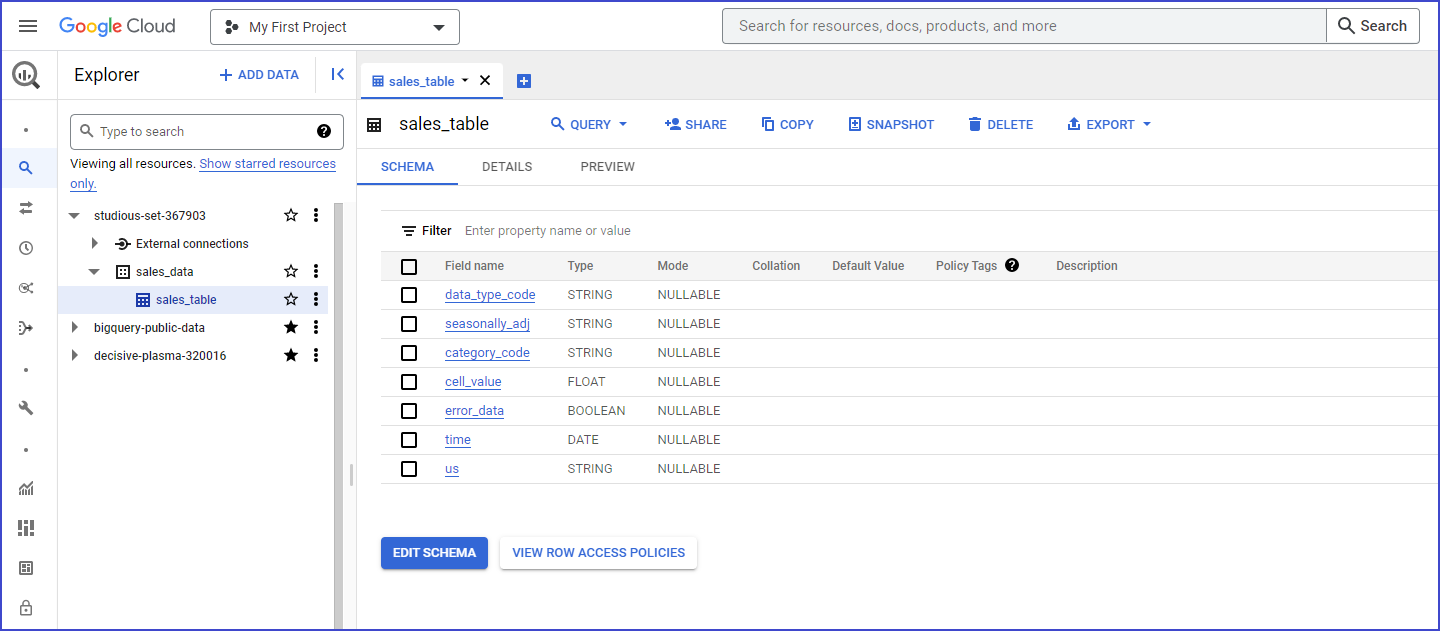

In [17]:
Image(filename='../img/BigQuery1.png')

&nbsp;
&nbsp;


Further data transformation can be perfomed on BigQuery (Standard SQL).



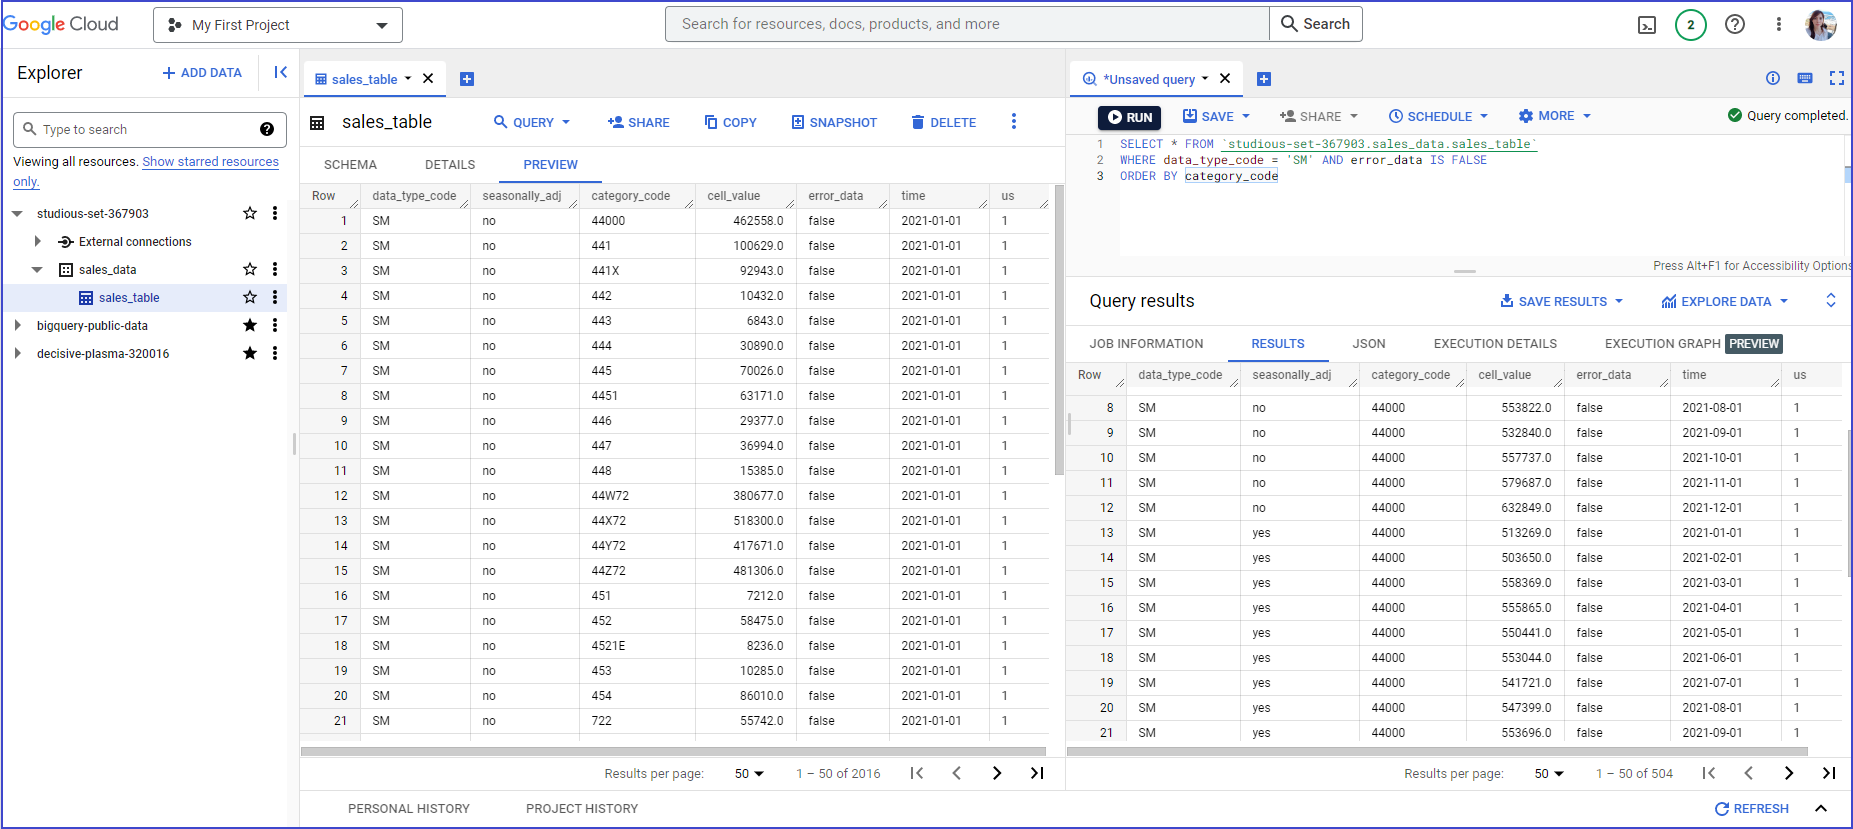

In [18]:
Image(filename='../img/Bigquery2.png')

&nbsp;

## <span style='color:steelblue'> Loading into Looker </span>

The final step is to perform data visualization. This can be achieved by loading the BigQuery table into Looker. 
To accomplish this task, Looker must connect to BigQuery through creating a service account or by generating OAuth credentials.
&nbsp;

Below, I include an example that was created in **Looker Studio** using the U.S. sales data to create a time series dashboard.

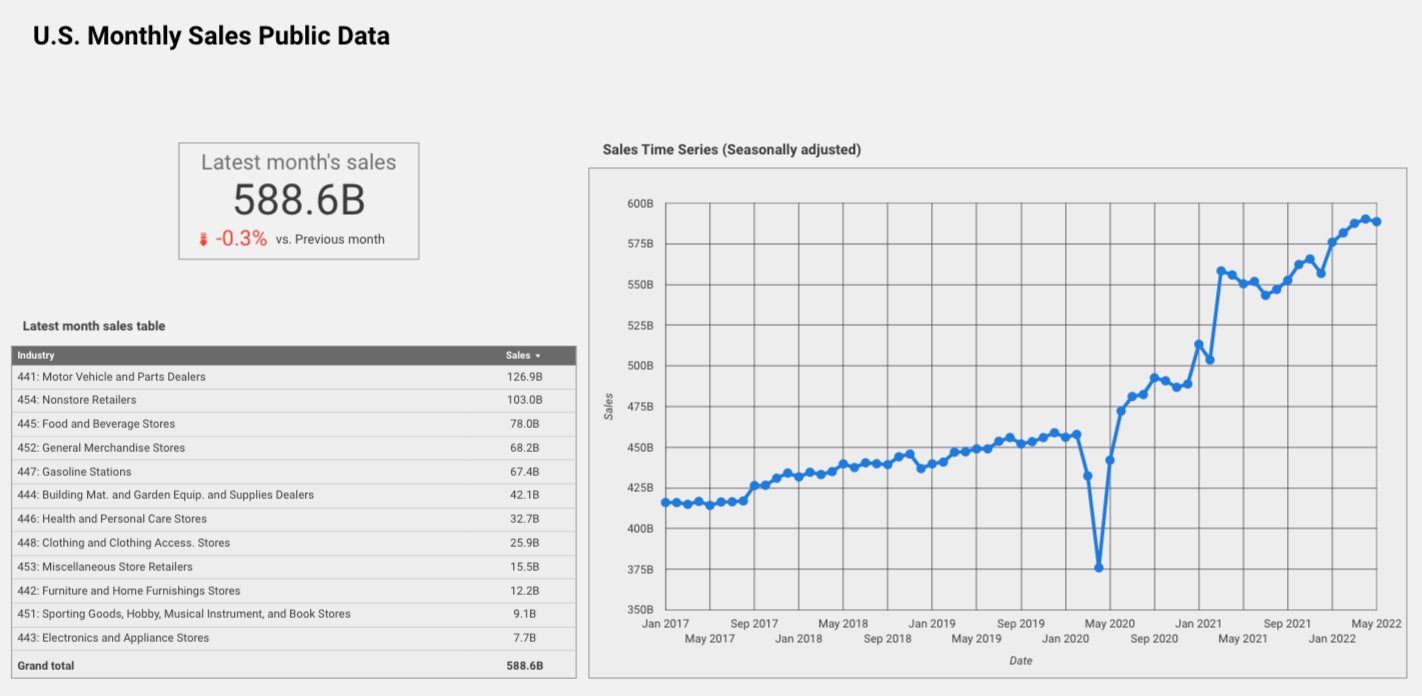

In [19]:
Image(filename='../img/dashboard.png')